# Practicality Check

The purpose of this notebook is to check whether the idea of trading off safety for efficiency by constraining the policy ratio can give useful results while maintaining reasonable bounds on safety.

In [84]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from abc import ABC, abstractmethod

# Set problem dimensions
STATE_DIM: int = 3
ACT_DIM: int = 2

In [85]:
# Set up CVXPY program
class ProjectionSolver():
        
    def __init__(self,
                 cp_beta: float = 1.0,
                 ) -> None:

        # Initialise variables and parameters (use cp prefix to avoid conflicts elsewhere)
        self.cp_eta = 1e-8 # used to enforce strict inequality

        self.cp_beta = cp.Parameter() # (> 1) constraint on maximum policy ratio

        assert cp_beta >= 1.0, "cp_beta must be >= 1.0"

        self.cp_beta.value = cp_beta

        # base policy (cvxpy parameters)
        self.cp_mu_base = cp.Parameter(ACT_DIM)
        self.cp_sig_base = cp.Parameter(ACT_DIM, pos=True)

        # task policy (cvxpy parameters)
        self.cp_mu_task = cp.Parameter(ACT_DIM)
        self.cp_sig_task = cp.Parameter(ACT_DIM, pos=True)

        # projected policy (cvxpy variables)
        self.cp_mu_proj = cp.Variable(ACT_DIM)
        self.cp_sig_proj = cp.Variable(ACT_DIM, pos=True)


        # Additional variables/parameters for DPP
        # base policy (cvxpy parameters)
        self.cp_sig_base_inv = cp.Parameter(ACT_DIM, pos=True) # 1/sig_base
        self.cp_sig_sig_base = cp.Parameter(ACT_DIM, pos=True) # sig_base^2

        # task policy (cvxpy parameters)
        self.cp_sig_task_inv = cp.Parameter(ACT_DIM, pos=True) # 1/sig_task
        self.cp_mu_sig_task = cp.Parameter(ACT_DIM) # mu_task/sig_task
        self.cp_mu_sig_sig_task = cp.Parameter(ACT_DIM)   # mu_task/(sig_task)^2

        # sum term (cvxpy variables)
        self.cp_mu_base_var = cp.Variable(ACT_DIM)   # mu_base
        self.cp_sig_sig_base_var = cp.Variable(ACT_DIM, pos=True)   # sig_base^2

        # Problem definition (as DPP)
        objective = (cp.Minimize(-2*cp.sum(cp.log(self.cp_sig_proj))
                                + cp.sum_squares(cp.multiply(self.cp_sig_proj,self.cp_sig_task_inv))
                                + cp.sum_squares(cp.multiply(self.cp_mu_proj,self.cp_sig_task_inv))
                                - 2*cp.sum(cp.multiply(self.cp_mu_proj, self.cp_mu_sig_sig_task))
                                + cp.sum_squares(self.cp_mu_sig_task)))

        constraints = []

        constraint_1 = self.cp_sig_proj + self.cp_eta <= self.cp_sig_base
        constraints.append(constraint_1)

        # we define the sum term like this so that we can use quad_over_lin and thus allow the
        # problem to be DCP (standard quotient operator is not DCP)
        # note that numerator gets squared (which we want)
        sum_term = 0
        for i in range(0, ACT_DIM):
            sum_term += cp.quad_over_lin(self.cp_mu_proj[i]-self.cp_mu_base_var[i],
                                         self.cp_sig_sig_base_var[i]-cp.square(self.cp_sig_proj[i]))

        constraint_2 = (-cp.sum(cp.log(self.cp_sig_base_inv))
                        - cp.sum(cp.log(self.cp_sig_proj))
                        + (1/2)*sum_term <= cp.log(self.cp_beta))
        constraints.append(constraint_2)

        constraint_3 = self.cp_mu_base_var == self.cp_mu_base
        constraints.append(constraint_3)

        constraint_4 = self.cp_sig_sig_base_var == self.cp_sig_sig_base
        constraints.append(constraint_4)

        self.cp_prob = cp.Problem(objective, constraints)

    def set_cp_beta(self, cp_beta:float) -> None:
        assert cp_beta >= 1.0, "cp_beta must be >= 1.0"
        self.cp_beta.value = cp_beta

    def get_proj_mean_std(self,
                          mean_base: np.ndarray,
                          std_base: np.ndarray,
                          mean_task: np.ndarray,
                          std_task: np.ndarray,
                          ) -> tuple[np.ndarray, np.ndarray]:

        # If beta set to 1 (or incorrectly < 1), just roll out the base policy
        if self.cp_beta.value <= 1.0:
            mean_proj = mean_base
            std_proj = std_base

        # Otherwise compute the projected policy
        else:
            # Set projection problem parameters
            self.cp_mu_base.value = mean_base
            self.cp_sig_base.value = std_base

            self.cp_mu_task.value = mean_task
            self.cp_sig_task.value = std_task

            self.cp_sig_base_inv.value = 1/std_base
            self.cp_sig_sig_base.value = np.square(std_base)

            self.cp_sig_task_inv.value = 1/std_task
            self.cp_mu_sig_task.value = mean_task/std_task
            self.cp_mu_sig_sig_task.value = mean_task/np.square(std_task)

            # Project into feasible set
            result = self.cp_prob.solve()

            # Extract projected mean and std
            mean_proj = self.cp_mu_proj.value
            std_proj = self.cp_sig_proj.value

        return mean_proj, std_proj

In [125]:
# Define environment
class Env():

    def __init__(self,
                 goal_pos: np.ndarray,
                 goal_r: float,
                 haz_pos: np.ndarray,
                 haz_r: float,
                 dt: float = 1.0,
                 env_noise_std: np.ndarray = 1e-4*np.ones(ACT_DIM),
                 env_start_mean: np.ndarray = np.zeros(STATE_DIM),
                 env_start_std: np.ndarray = np.ones(STATE_DIM),
                 ) -> None:
        self.goal_pos = goal_pos
        self.goal_r = goal_r
        self.haz_pos = haz_pos
        self.haz_r = haz_r
        self.dt = dt
        self.env_noise_std = env_noise_std
        self.env_start_mean = env_start_mean
        self.env_start_std = env_start_std

    def reset(self,
              norm_init_state: np.ndarray,
              ) -> np.ndarray:
        init_state = self.env_start_mean + norm_init_state * self.env_start_std
        return init_state
    
    def is_in_goal(self,
                   state: np.ndarray,
                   ) -> bool:
        if np.linalg.norm(self.goal_pos - state[0:2]) <= self.goal_r:
            return True
        else:
            return False
        
    def is_in_haz(self,
                  state: np.ndarray,
                  ) -> bool:
        if np.linalg.norm(self.haz_pos - state[0:2]) <= self.haz_r:
            return True
        else:
            return False

    def step(self,
             state: np.ndarray,
             norm_action: np.ndarray,
             act_mean: np.ndarray,
             act_std: np.ndarray,
             norm_noise: np.ndarray,
             ) -> tuple[np.ndarray, bool, bool]:
        next_state = np.empty(shape=(STATE_DIM))
        v = act_mean[0] + norm_action[0] * act_std[0] + norm_noise[0] * self.env_noise_std[0]
        omega = act_mean[1] + norm_action[1] * act_std[1] + norm_noise[1] * self.env_noise_std[1]
        next_state[0] = state[0] + self.dt * v * np.cos(state[2] + self.dt * omega)
        next_state[1] = state[1] + self.dt * v * np.sin(state[2] + self.dt * omega)
        next_state[2] = state[2] + self.dt * omega

        return next_state, self.is_in_goal(next_state), self.is_in_haz(next_state)

In [146]:
# Policy abstract base class
class Policy(ABC):

    @abstractmethod
    def get_mean_std(self,
                     state: np.ndarray,
                     ) -> np.ndarray:
        pass

# Define base policy
class BasePolicy(Policy):

    def __init__(self,
                 goal_pos: np.ndarray,
                 goal_r: float,
                 haz_pos: np.ndarray,
                 haz_r: float,
                 avoidance_r: float,
                 policy_std: np.ndarray,
                 max_step_size: np.ndarray,
                 avoidance_factor: float = 10.0,
                 ) -> None:
        super().__init__()
        self.goal_pos = goal_pos
        self.goal_r = goal_r
        self.haz_pos = haz_pos
        self.haz_r = haz_r
        self.avoidance_r = avoidance_r
        self.policy_std = policy_std
        self.max_step_size = max_step_size
        self.avoidance_factor = avoidance_factor
    
    def get_mean_std(self,
                     state: np.ndarray,
                     ) -> tuple[np.ndarray, np.ndarray]:
        vec_to_goal = self.goal_pos - state[0:2]

        vec_from_haz = state[0:2] - self.haz_pos

        vec_combined = (vec_to_goal
                        + vec_from_haz * max(0,min(1/self.haz_r, 1/np.linalg.norm(vec_from_haz)) - 1/(self.haz_r + self.avoidance_r))
                        * 1/(1/self.haz_r - 1/(self.haz_r + self.avoidance_r)) * self.avoidance_factor)

        vel = np.linalg.norm(vec_combined)
        omg = np.arctan2(vec_combined[1],vec_combined[0]) - state[2]
        
        action = np.zeros(ACT_DIM)
        action[0] = max(-self.max_step_size[0],min(vel, self.max_step_size[0]))
        action[1] = max(-self.max_step_size[1],min(omg, self.max_step_size[1]))
        
        return action, self.policy_std

# Define task policy
class TaskPolicy(Policy):

    def __init__(self,
                 goal_pos: np.ndarray,
                 goal_r: float,
                 haz_pos: np.ndarray,
                 haz_r: float,
                 policy_std: np.ndarray,
                 max_step_size: np.ndarray,
                 ) -> None:
        super().__init__()
        self.goal_pos = goal_pos
        self.goal_r = goal_r
        self.haz_pos = haz_pos
        self.haz_r = haz_r
        self.policy_std = policy_std
        self.max_step_size = max_step_size
    
    def get_mean_std(self,
                     state: np.ndarray,
                     ) -> tuple[np.ndarray, np.ndarray]:
        vec_to_goal = self.goal_pos - state[0:2]

        vel = np.linalg.norm(vec_to_goal)
        omg = np.arctan2(vec_to_goal[1],vec_to_goal[0]) - state[2]
        
        action = np.zeros(ACT_DIM)
        action[0] = max(-self.max_step_size[0],min(vel, self.max_step_size[0]))
        action[1] = max(-self.max_step_size[1],min(omg, self.max_step_size[1]))
        
        return action, self.policy_std


In [147]:
# Trajectory generator class
class TrajectoryGenerator():

    def __init__(self,
                 goal_pos: np.ndarray,
                 goal_r: float,
                 haz_pos: np.ndarray,
                 haz_r: float,
                 avoidance_r: float,
                 base_policy_std: np.ndarray,
                 task_policy_std: np.ndarray,
                 max_step_size: np.ndarray,
                 avoidance_factor: float = 10.0,
                 dt: float = 1.0,
                 env_noise_std: np.ndarray = 1e-4*np.ones(ACT_DIM),
                 env_start_mean: np.ndarray = np.zeros(STATE_DIM),
                 env_start_std: np.ndarray = np.ones(STATE_DIM),
                 cp_beta: float = 1.0,
                ) -> None:
        
        self.env = Env(goal_pos=goal_pos,
                       goal_r=goal_r,
                       haz_pos=haz_pos,
                       haz_r=haz_r,
                       dt=dt,
                       env_noise_std=env_noise_std,
                       env_start_mean=env_start_mean,
                       env_start_std=env_start_std,
                       )
        self.base_policy = BasePolicy(goal_pos=goal_pos,
                                      goal_r=goal_r,
                                      haz_pos=haz_pos,
                                      haz_r=haz_r,
                                      avoidance_r=avoidance_r,
                                      policy_std=base_policy_std,
                                      max_step_size=max_step_size,
                                      avoidance_factor=avoidance_factor,
                                      )
        self.task_policy = TaskPolicy(goal_pos=goal_pos,
                                      goal_r=goal_r,
                                      haz_pos=haz_pos,
                                      haz_r=haz_r,
                                      policy_std=task_policy_std,
                                      max_step_size=max_step_size,
                                      )
        self.proj_solver = ProjectionSolver(cp_beta=cp_beta)

    def set_cp_beta(self,
                    cp_beta: float,
                    ) -> None:
        self.proj_solver.set_cp_beta(cp_beta)

    def set_goal_pos(self,
                     goal_pos: np.ndarray,
                     ) -> None:
        self.env.goal_pos = goal_pos
        self.base_policy.goal_pos = goal_pos
        self.task_policy.goal_pos = goal_pos

    def generate_trajectories(self,
                              num: int,
                              length:int,
                              mode:str = 'default',
                              seed:int = 0,
                              ) -> tuple[np.ndarray, list, list, list]:
        traj_array = np.empty(shape=(num, length+1, STATE_DIM))
        entered_hazard_list = []
        reached_goal_list = []
        time_to_goal_list = []
        rng = np.random.default_rng(seed)
        for i in range(0, num):
            entered_hazard = False
            reached_goal = False
            state = self.env.reset(rng.normal(size=STATE_DIM))
            traj_array[i][0][:] = state
            for t in range(1,length+1):
                
                mean_base, std_base = self.base_policy.get_mean_std(state)
                mean_task, std_task = self.task_policy.get_mean_std(state)

                if mode == 'base':
                    act_mean, act_std = mean_base, std_base
                elif mode == 'task':
                    act_mean, act_std = mean_task, std_task
                else:
                    act_mean, act_std = self.proj_solver.get_proj_mean_std(mean_base, std_base, mean_task, std_task)
                state, goal, haz = self.env.step(state, rng.normal(size=ACT_DIM), act_mean, act_std, rng.normal(size=ACT_DIM))
                traj_array[i][t][:] = state
                if goal and reached_goal == False:
                    reached_goal_list.append(True)
                    time_to_goal_list.append(t)
                    reached_goal = True
                if haz and entered_hazard == False:
                    entered_hazard_list.append(True)
                    entered_hazard = True

            if reached_goal == False:
                reached_goal_list.append(False)
                time_to_goal_list.append(np.nan)

            if entered_hazard == False:
                entered_hazard_list.append(False)

        return traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list

In [342]:
# Experiment runner
def run_experiment(traj_generator: TrajectoryGenerator,
                   traj_num: int,
                   traj_length: int,
                   seed: int,
                   beta_list: list,
                   beta_color_list: list,
                   ) -> dict:
    assert len(beta_list) == len(beta_color_list), "beta_list and beta_color_list must be the same length"
    traj_dict = {}
    for beta in beta_list:
        print('Computing trajectories for beta = '+str(beta))
        if beta == 'base':
            traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=traj_num,
                                                                                                                         length=traj_length,
                                                                                                                         mode='base',
                                                                                                                         seed=seed)
            traj_dict[beta] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, beta_color_list[beta_list.index(beta)]]
        elif beta == 'task':
            traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=traj_num,
                                                                                                                         length=traj_length,
                                                                                                                         mode='task',
                                                                                                                         seed=seed)
            traj_dict[beta] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, beta_color_list[beta_list.index(beta)]]
        elif type(beta) == float:
            assert beta >= 1.0, "beta must be greater than or equal to 1.0"
            traj_generator.set_cp_beta(beta)
            traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list = traj_generator.generate_trajectories(num=traj_num,
                                                                                                                         length=traj_length,
                                                                                                                         mode='default',
                                                                                                                         seed=seed)
            traj_dict[beta] = [traj_array, entered_hazard_list, reached_goal_list, time_to_goal_list, beta_color_list[beta_list.index(beta)]]
        else:
            raise ValueError("Invalid beta ("+str(beta)+"). Beta must be either 'base', 'task' or a float >= 1.0.")
    print('Done')
    return traj_dict

In [343]:
# Environment params
START_X = 0.0
START_Y = 0.0
START_R = 3.0

GOAL_X = 80.0
GOAL_Y = 0.0
GOAL_R = 10.0

HAZ_X = 40.0
HAZ_Y = -5.0
HAZ_R = 10.0

DT = 1.0

In [344]:
# Experiment params
base_policy_std=np.array([8e-1,8e-1])
task_policy_std=np.array([1e-2,1e-2])
max_step_size=np.array([2e0,3e0])
avoidance_r=30.0
avoidance_factor=15.0
env_noise_std=np.array([1e-3,1e-3])
env_start_mean=np.array([START_X,START_Y,0.0])
env_start_std=np.array([START_R/3,START_R/3,1e0])
traj_num = 10
traj_length = 100
seed = 0

In [345]:
# Values of beta to test
beta_list = ['base',1.02,1.1,1.5,2.0,5.0,10.0,30.0,'task']
beta_color_list = ['blue','grey','pink','yellow','green','cyan','orangered','purple','orange']

In [309]:
# DEBUG: run if you only want to test task and base policy
beta_list = ['base','task']
beta_color_list = ['blue','orange']

In [346]:
# Instantiate trajectory generator
traj_generator=TrajectoryGenerator(goal_pos=np.array([GOAL_X,GOAL_Y]),
                                   goal_r=GOAL_R,
                                   haz_pos=np.array([HAZ_X,HAZ_Y]),
                                   haz_r=HAZ_R,
                                   avoidance_r=avoidance_r,
                                   base_policy_std=base_policy_std,
                                   task_policy_std=task_policy_std,
                                   max_step_size=max_step_size,
                                   avoidance_factor=avoidance_factor,
                                   dt=DT,
                                   env_noise_std=env_noise_std,
                                   env_start_mean=env_start_mean,
                                   env_start_std=env_start_std,
                                   )

In [347]:
# Run experiment
traj_dict = run_experiment(traj_generator=traj_generator,
                           traj_num=traj_num,
                           traj_length=traj_length,
                           seed=seed,
                           beta_list=beta_list,
                           beta_color_list=beta_color_list)

Computing trajectories for beta = base
Computing trajectories for beta = 1.02


/home/jacques/miniconda3/envs/rl-safety-filters/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Computing trajectories for beta = 1.1
Computing trajectories for beta = 1.5
Computing trajectories for beta = 2.0
Computing trajectories for beta = 5.0
Computing trajectories for beta = 10.0
Computing trajectories for beta = 30.0
Computing trajectories for beta = task
Done


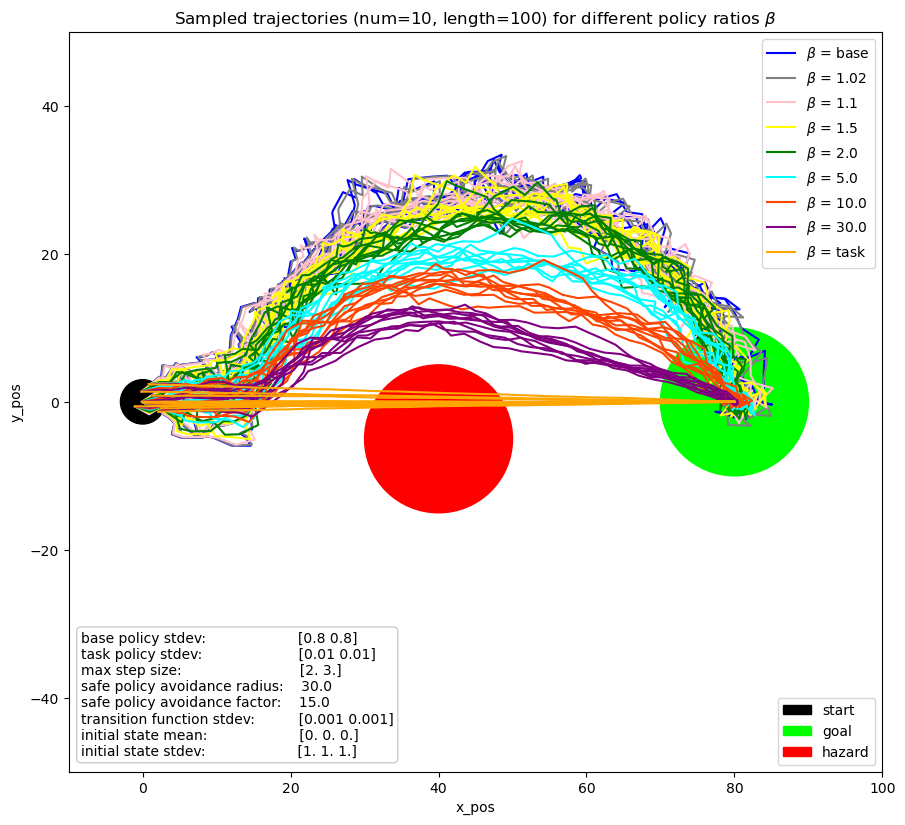

β         fail prob factor bound   time to goal (avg)       speed-up factor (avg)    hazard hit rate          goal reach rate          
base      1.0                      72.8                     1.00                     0.0                      100.0                    
1.02      7.2                      71.9                     1.01                     0.0                      100.0                    
1.1       13780.6                  68.8                     1.06                     0.0                      100.0                    
1.5       >1000000000.0            60.1                     1.21                     0.0                      100.0                    
2.0       >1000000000.0            56.2                     1.30                     0.0                      100.0                    
5.0       >1000000000.0            47.5                     1.53                     0.0                      100.0                    
10.0      >1000000000.0            43.0         

In [385]:
# Plot trajectories
start = plt.Circle((START_X,START_Y), START_R, color='black', label='start')
goal = plt.Circle((GOAL_X,GOAL_Y), GOAL_R, color='lime', label='goal')
haz = plt.Circle((HAZ_X,HAZ_Y), HAZ_R, color='red', label='hazard')

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 10.5)

ax.add_patch(start)
ax.add_patch(goal)
ax.add_patch(haz)
patch_legend = ax.legend(handles=[start,goal,haz], loc='lower right')
ax.add_artist(patch_legend)

l = []

for key in traj_dict.keys():
    for i in range(0,traj_dict[key][0].shape[0]):
        plt.plot(traj_dict[key][0][i,:,0],traj_dict[key][0][i,:,1], color=traj_dict[key][4])
    l.append(mlines.Line2D([],[], color=traj_dict[key][4], label=r'$\beta$ = '+str(key)))

ax.set_xlim(-10,100)
ax.set_xlabel('x_pos')
ax.set_ylim(-50,50)
ax.set_ylabel('y_pos')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

ax.legend(handles=l, loc='upper right')
ax.set_title('Sampled trajectories (num='+str(traj_num)+', length='+str(traj_length)+') for different policy ratios '+r'$\beta$')

textstr = "\n".join((f'{"base policy stdev:":<39}{base_policy_std}',
                     f'{"task policy stdev:":<40}{task_policy_std}',
                     f'{"max step size:":<41}{max_step_size}',
                     f'{"safe policy avoidance radius:":<33}{avoidance_r}',
                     f'{"safe policy avoidance factor:":<33}{avoidance_factor}',
                     f'{"transition function stdev:":<36}{env_noise_std}',
                     f'{"initial state mean:":<40}{env_start_mean}',
                     f'{"initial state stdev:":<41}{env_start_std}'))

props = dict(boxstyle='round', facecolor='white', alpha=0.2)
ax.text(0.015, 0.19, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)

plt.show()

# Print table of results
beta_str = "\u03B2"
base_str = "base"
max_violation_prob_factor = 1e9
print(f'{beta_str:<10}'
      f'{"fail prob factor bound":<25}'
      f'{"time to goal (avg)":<25}'
      f'{"speed-up factor (avg)":<25}'
      f'{"hazard hit rate":<25}'
      f'{"goal reach rate":<25}')
for key in traj_dict.keys():
    if key == 'base':
        violation_prob_factor = 1.0
        greater_than_str = ''
    elif key == 'task':
        violation_prob_factor = np.nan
        greater_than_str = ''
    else:
        violation_prob_factor = 1.0
        for t in range(0,traj_length):
            violation_prob_factor *= key
            if violation_prob_factor >= max_violation_prob_factor:
                violation_prob_factor = max_violation_prob_factor
                greater_than_str = '>'
                break
    print(f'{str(key):<10}'
          f'{greater_than_str+f"{violation_prob_factor:.1f}":<25}'
          f'{f"{np.nanmean(traj_dict[key][3]):.1f}":<25}'
          f'{f"{np.nanmean(traj_dict[base_str][3])/np.nanmean(traj_dict[key][3]):.2f}":<25}'
          f'{f"{np.mean(traj_dict[key][1])*100:.1f}":<25}'
          f'{f"{np.mean(traj_dict[key][2])*100:.1f}":<25}')